In [1]:
import pandas as pd, numpy as np
import os
import glob
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 15, 8
from sklearn.metrics import mean_squared_error
import math, itertools
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from fbprophet import Prophet

## Dataset import and time-series generation 
 - importing dataset containing timestamp of each checkin for the businesses

In [3]:
check_df = pd.concat([pd.read_parquet(f) for f in glob.glob(os.getcwd()+'/filtered_data/checkin/*.parquet')], ignore_index=True)

In [4]:
print("Shape:",check_df.shape)
print("No. of business:",len(check_df.business_id.unique()))
check_df.head()

Shape: (40632, 2)
No. of business: 40632


business_id                                               date
0  -6c_bJblLXUwoWfmYLtH_w  2017-09-11 21:09:29, 2017-09-13 19:44:34, 2018...
1  -Gh9a15ijNii-8rnp4x3xA                                2015-01-28 16:13:00
2  -TGwtTiieh_JLml5_VRMQA  2010-08-21 19:05:19, 2011-04-08 13:34:47, 2011...
3  -VAsjhmAbKF3Pb_-8rh3xg  2013-09-09 21:24:17, 2013-09-11 16:10:00, 2013...
4  -r8SvItXXG6_T3mP5GXRAw  2011-03-21 21:08:34, 2011-09-09 19:08:55, 2011...

- splitting the string and exploding the list to get individual timestamps as a record 
- type casting timestamp string to datetime  

In [5]:
check_df['date'] = check_df.date.apply(lambda x: x.split(','))
check_df = check_df.explode('date').reset_index().drop('index',axis=1)
check_df['date'] = pd.to_datetime(check_df.date)
check_df.head()

business_id                date
0  -6c_bJblLXUwoWfmYLtH_w 2017-09-11 21:09:29
1  -6c_bJblLXUwoWfmYLtH_w 2017-09-13 19:44:34
2  -6c_bJblLXUwoWfmYLtH_w 2018-02-20 22:01:45
3  -6c_bJblLXUwoWfmYLtH_w 2018-03-14 21:39:04
4  -6c_bJblLXUwoWfmYLtH_w 2018-03-23 23:14:52

In [6]:
check_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083371 entries, 0 to 2083370
Data columns (total 2 columns):
 #   Column       Dtype         
---  ------       -----         
 0   business_id  object        
 1   date         datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 31.8+ MB


- importing dataset containing location information of businesses

In [7]:
bus_df = pd.concat([pd.read_parquet(f) for f in glob.glob(os.getcwd()+'/filtered_data/business/*.parquet')], ignore_index=True)

In [8]:
print("Shape:",bus_df.shape)
print("No. of business:",len(bus_df.business_id.unique()))
print("No. of cities:",len(bus_df.city.unique()))
print("Cities:",list(bus_df.city.unique()))
print("Provinces:",list(bus_df.state.unique()))
bus_df.head()

Shape: (47110, 58)
No. of business: 47110
No. of cities: 10
Cities: ['Toronto', 'Calgary', 'Richmond Hill', 'Montréal', 'Scarborough', 'Markham', 'Mississauga', 'Brampton', 'Vaughan', 'North York']
Provinces: ['ON', 'AB', 'QC', 'BC', 'YT', 'MB', 'AL', 'OH']


city                       address             business_id  \
0        Toronto  700 Kipling Avenue Etobicoke  EosRKXIGeSWFYWwpkbhNnA   
1        Calgary                                MbZMmwo-eL0Jnm_Yb9KJrA   
2        Toronto              306 Yonge Street  1wWneWD_E1pBIyVpdHMaQg   
3        Toronto             415 Horner Avenue  007Dg4ESDVacWcC4Vq704Q   
4  Richmond Hill            13071 Yonge Street  9sRGfSVEfLhN_km60YruTA   

                                          categories  is_open   latitude  \
0  Martial Arts, Gyms, Fitness & Instruction, Act...      1.0  43.624539   
1            Contractors, Landscaping, Home Services      1.0  50.945960   
2                     Shopping, Shoe Stores, Fashion      1.0  43.656542   
3  Shopping, Food, Organic Stores, Specialty Food...      0.0  43.603232   
4  Persian/Iranian, Turkish, Middle Eastern, Rest...      1.0  43.947011   

    longitude                            name postal_code  review_count  ...  \
0  -79.529108                  Xtreme Couture     M8Z 5G3          16.0  ...   
1 -114.037207  Chinook Landscaping and Design     T2J 2P2           3.0  ...   
2  -79.381308                Air Jordan Store     M5B 1R4           9.0  ...   
3  -79.538424             Front Door Organics     M8W 4W3           8.0  ...   
4  -79.454862              Apadana Restaurant     L4E 1A5           3.0  ...   

   attributes.Smoking attributes.WheelchairAccessible attributes.WiFi  \
0                None                            None            None   
1                None                            None            None   
2                None                            None            None   
3                None                            None            None   
4                None                            True         u'free'   

  hours.Friday hours.Monday hours.Saturday hours.Sunday hours.Thursday  \
0    5:30-23:0    5:30-23:0       8:0-19:0     8:0-17:0      5:30-23:0   
1     7:0-17:0     7:0-17:0       7:0-17:0         None       7:0-17:0   
2    10:0-21:0    10:0-21:0      9:30-21:0    11:0-19:0      10:0-21:0   
3     9:0-16:0     9:0-16:0           None         None       9:0-16:0   
4     12:0-0:0         None       12:0-0:0    11:0-21:0      12:0-21:0   

  hours.Tuesday hours.Wednesday  
0     5:30-23:0       5:30-23:0  
1      7:0-17:0        7:0-17:0  
2     10:0-21:0       10:0-21:0  
3      9:0-16:0        9:0-16:0  
4     12:0-21:0       12:0-21:0  

[5 rows x 58 columns]

- converting Montréal (accented) -> Montreal (unaccented)

In [9]:
import unidecode

bus_df['city'] = bus_df.city.apply(lambda x: unidecode.unidecode(x))
bus_df['state'] = np.select(
    [
        bus_df['city'].isin(['Toronto', 'Richmond Hill', 'Scarborough', 'Markham', 'Mississauga', 'Brampton', 'Vaughan', 'North York']),
        bus_df['city'].isin(['Calgary']),
        bus_df['city'].isin(['Montreal']),
    ],
    [
        'ON',
        'AB',
        'QC'
    ]
)

In [10]:
df = bus_df[['business_id','city']].merge(check_df,on=['business_id'],how='inner')
df['city'] = df.city.astype('category')
df.dtypes

business_id            object
city                 category
date           datetime64[ns]
dtype: object

In [11]:
df['date'] = df.date.dt.date
df.head()

business_id     city        date
0  EosRKXIGeSWFYWwpkbhNnA  Toronto  2012-06-12
1  EosRKXIGeSWFYWwpkbhNnA  Toronto  2013-02-11
2  EosRKXIGeSWFYWwpkbhNnA  Toronto  2013-02-22
3  EosRKXIGeSWFYWwpkbhNnA  Toronto  2013-03-05
4  EosRKXIGeSWFYWwpkbhNnA  Toronto  2013-03-06

In [12]:
pivot_df = df.pivot_table(index='date',values='business_id',columns='city',aggfunc='count', fill_value=0)
pivot_df.index = pd.DatetimeIndex(pivot_df.index)
pivot_df

city        Brampton  Calgary  Markham  Mississauga  Montreal  North York  \
date                                                                        
2010-01-16         1        8        0            0         1           0   
2010-01-17         0       10        0            0         3           1   
2010-01-18         0        4        4            0         0           0   
2010-01-19         0        2        0            0         0           1   
2010-01-20         0        8        0            3         3           1   
...              ...      ...      ...          ...       ...         ...   
2019-12-09         2       13       26           36        22          10   
2019-12-10         1       13       25           28        32           9   
2019-12-11         4       10       15           30        34           5   
2019-12-12         3        7       40           40        47           7   
2019-12-13         0        7       11           15        29           4   

city        Richmond Hill  Scarborough  Toronto  Vaughan  
date                                                      
2010-01-16              0            2       27        0  
2010-01-17              0            1       29        0  
2010-01-18              0            2       21        0  
2010-01-19              0            0       25        0  
2010-01-20              0            0       37        0  
...                   ...          ...      ...      ...  
2019-12-09              6           15      115        6  
2019-12-10             13            9      204        5  
2019-12-11              9            3      180        4  
2019-12-12             10           16      147        3  
2019-12-13              6            5      100        2  

[3619 rows x 10 columns]

- monthly aggregate of checkins for all businesses in cities 

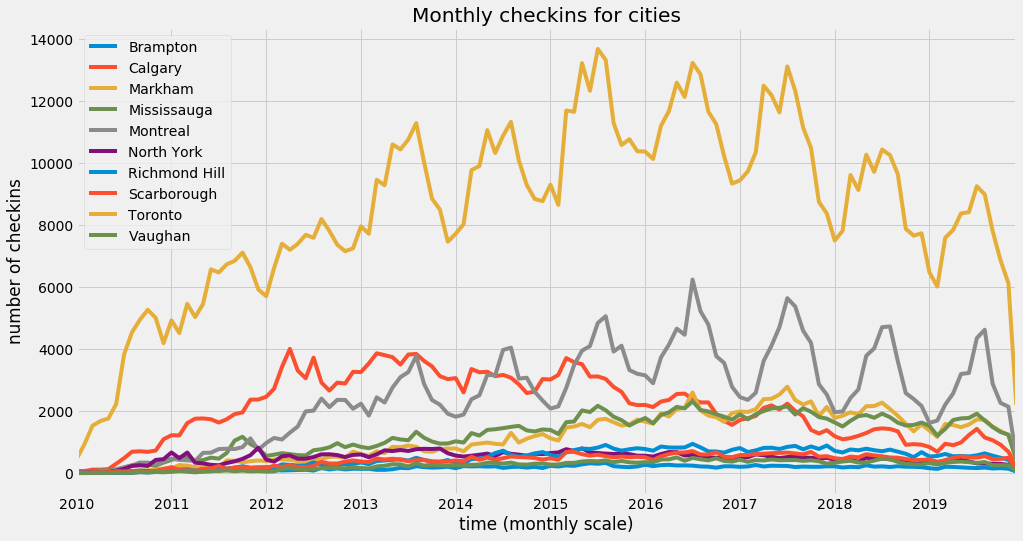

In [13]:
fig,ax=plt.subplots(figsize=(15,8))

cities = list(pivot_df.columns)
for i in range(10):
    pivot_df.loc[:,cities[i]].resample('M').sum().plot(ax=ax)
ax.set(title='Monthly checkins for cities',xlabel='time (monthly scale)', \
       ylabel='number of checkins')
plt.legend()
plt.show()

- choosing 'Toronto' for further time series analysis and estimating parameters for different forecasting techniques
- aggregating data on two levels - 'daily', 'monthly'

In [14]:
daily_tor = pivot_df.loc[pivot_df.index>'2012-12-31','Toronto'].resample('D').sum().reset_index().rename(columns={'date':'ds','Toronto':'y'}).set_index('ds')

monthly_tor = pivot_df.loc[pivot_df.index>'2012-12-31','Toronto'].resample('M').sum().reset_index().rename(columns={'date':'ds','Toronto':'y'}).set_index('ds')


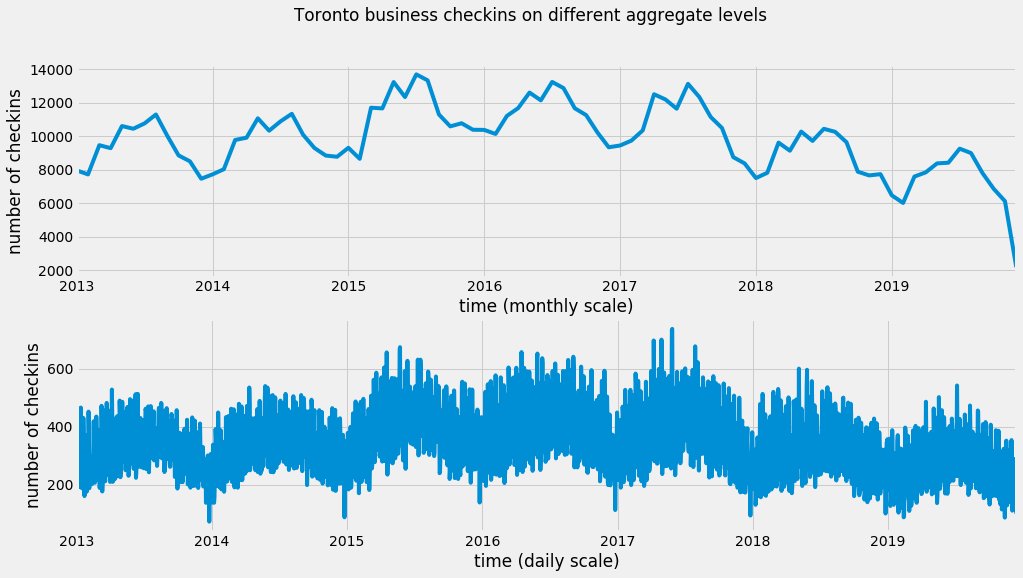

In [15]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
monthly_tor.plot(ax=ax[0],legend=False)
daily_tor.plot(ax=ax[1],legend=False)
ax[0].set(xlabel='time (monthly scale)',ylabel='number of checkins')
ax[1].set(xlabel='time (daily scale)',ylabel='number of checkins')
fig.suptitle('Toronto business checkins on different aggregate levels')
plt.show()

## Stationarity test
- testing time series stationarity using Augmented Dickey-Fuller test

In [16]:
def test_stationarity(ts_df):
    dftest = adfuller(ts_df.dropna())
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print('\tTest statistic: ', dfoutput['Test Statistic'], 'p-value: ', dfoutput['p-value'])
    if dfoutput['Test Statistic'] <= dfoutput['Critical Value (1%)']:
        print ("\tNull hypothesis can be rejected with 99% confidence - TS is Stationary")
    elif dfoutput['Test Statistic'] <= dfoutput['Critical Value (5%)']:
        print ("\tNull hypothesis can be rejected with 95% confidence - TS is Stationary")
    elif dfoutput['Test Statistic'] <= dfoutput['Critical Value (10%)']:
        print ("\tNull hypothesis can be rejected with 80% confidence - TS is Stationary")
    else:
        print ("\tNull hypothesis is accepted - TS is Non-Stationary")

In [17]:
print('Monthly TS:')
test_stationarity(monthly_tor)
print('Monthly TS (First difference):')
test_stationarity(monthly_tor.diff())
print('Monthly TS (Second Difference):')
test_stationarity(monthly_tor.diff().dropna().diff())

Monthly TS:
	Test statistic:  0.7757432886780382 p-value:  0.991234356001858
	Null hypothesis is accepted - TS is Non-Stationary
Monthly TS (First difference):
	Test statistic:  -0.9150292921118064 p-value:  0.7829827728341168
	Null hypothesis is accepted - TS is Non-Stationary
Monthly TS (Second Difference):
	Test statistic:  -5.775182021103398 p-value:  5.279689232600362e-07
	Null hypothesis can be rejected with 99% confidence - TS is Stationary


In [18]:
print('Daily TS:')
test_stationarity(daily_tor)
print('Daily TS (First Difference):')
test_stationarity(daily_tor.diff())
print('Daily TS (Second Difference):')
test_stationarity(daily_tor.diff().dropna().diff())

Daily TS:
	Test statistic:  -1.46201217673318 p-value:  0.5522127529780338
	Null hypothesis is accepted - TS is Non-Stationary
Daily TS (First Difference):
	Test statistic:  -13.986568414978223 p-value:  4.0872988016545555e-26
	Null hypothesis can be rejected with 99% confidence - TS is Stationary
Daily TS (Second Difference):
	Test statistic:  -20.775899317394263 p-value:  0.0
	Null hypothesis can be rejected with 99% confidence - TS is Stationary


- Daily aggregated time series seems to be better for further analysis
- Time series with first order difference is stationary - therefore d=1

## Forecasting

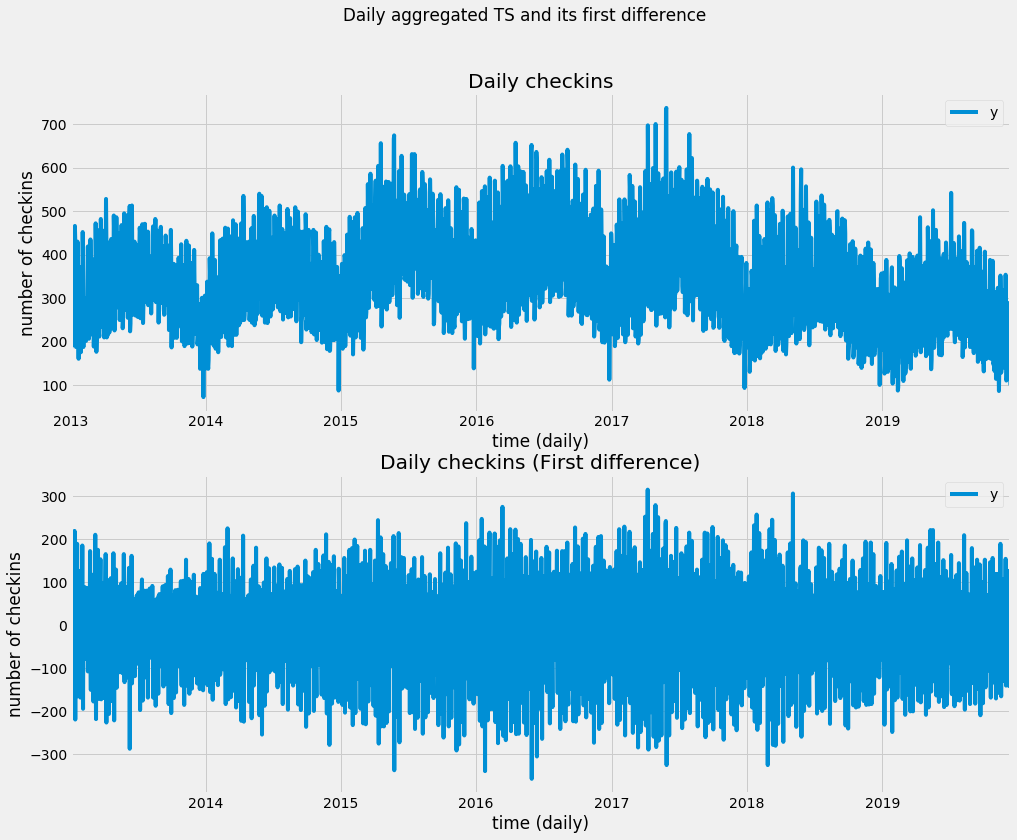

In [19]:
fig,ax = plt.subplots(2,1,figsize=(15,12))
daily_tor.plot(ax=ax[0])
daily_tor.diff().dropna().plot(ax=ax[1])
ax[0].set(title='Daily checkins', xlabel='time (daily)', ylabel='number of checkins')
ax[1].set(title='Daily checkins (First difference)', xlabel='time (daily)', ylabel='number of checkins')
fig.suptitle('Daily aggregated TS and its first difference')
plt.show()

- plotting ACF and PACF to identify auto-regression and moving average parameters

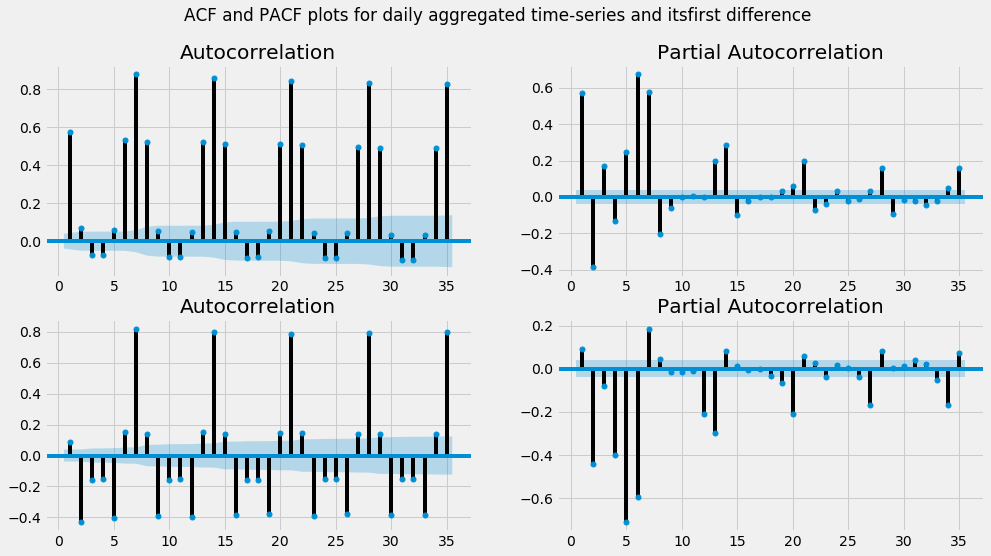

In [20]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
plot_acf(daily_tor,ax=ax[0][0],zero=False)
plot_acf(daily_tor.diff().dropna(),ax=ax[1][0],zero=False)
plot_pacf(daily_tor,ax=ax[0][1],zero=False)
plot_pacf(daily_tor.diff().dropna(),ax=ax[1][1],zero=False)
fig.suptitle('ACF and PACF plots for daily aggregated time-series and itsfirst difference')
plt.show()

- train and test split of time series for estimating performance of different forecasting models 

In [21]:
def train_test_split(ts_df):
    test_split = '2019-01-01'
    train = ts_df.loc[ts_df.index < test_split].copy()
    test = ts_df.loc[(ts_df.index >= test_split)].copy()
    print(train.shape)
    print(test.shape)
    return (train,test)

d_train, d_test = train_test_split(daily_tor)
error_vals = list()

(2191, 1)
(347, 1)


### Baseline seasonal persistence model

In [22]:
rmse_train = 10000000
years = range(1,len(daily_tor.index.year.unique()[:-1]))
scores = list()
for year in years:
    history = [x for x in d_train[:-1*d_test.shape[0]].values]
    predictions = list()
    for i in range(d_test.shape[0]):
        obs = list()
        for y in range(1, year+1):
            obs.append(history[-(y*365)])
        yhat = np.mean(obs)
        predictions.append(yhat)
        history.append(d_train[-1*d_test.shape[0]:].values[i])
    rmse = math.sqrt(mean_squared_error(d_train[-1*d_test.shape[0]:].values,predictions))
    scores.append(rmse)
    if rmse < rmse_train:
        rmse_train = rmse
        best_year = year
    print('Years=%d, RMSE: %.3f' % (year, rmse))

Years=1, RMSE: 128.675
Years=2, RMSE: 145.738
Years=3, RMSE: 147.335
Years=4, RMSE: 138.379
Years=5, RMSE: 130.638


In [23]:
prediction = list()
history = d_train[:-1*d_test.shape[0]].values.tolist()
for i in range(d_test.shape[0]):
    obs = list()
    for y in range(1, best_year+1):
        obs.append(history[-(y*365)])
    yhat = np.mean(obs)
    prediction.append(yhat)
    history.append(d_train[-1*d_test.shape[0]:].values[i])

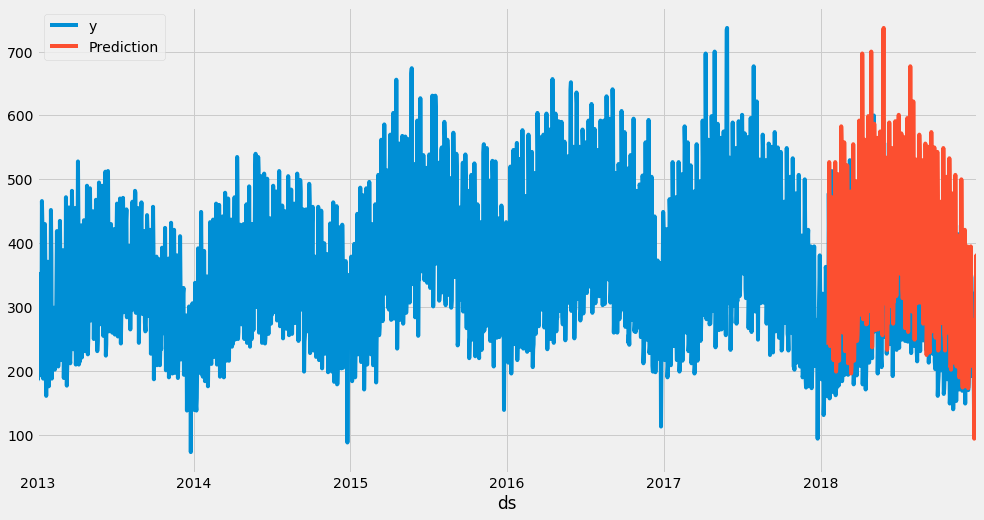

In [24]:
fig, ax = plt.subplots()
d_train.plot(label='observed',ax=ax)
pd.DataFrame(prediction,index=d_train[-1*d_test.shape[0]:].index,columns=['Prediction']).plot(ax=ax)
plt.legend()
plt.show()

In [25]:
rmse_train = math.sqrt(mean_squared_error(d_train[-1*d_test.shape[0]:].values,prediction))
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is 128.6752273012854.


In [26]:
forecast = list()
history = d_train.values.tolist()
for i in range(d_test.shape[0]):
    obs = list()
    for y in range(1, best_year+1):
        obs.append(history[-(y*365)])
    yhat = np.mean(obs)
    forecast.append(yhat)
    history.append(d_test.values[i])

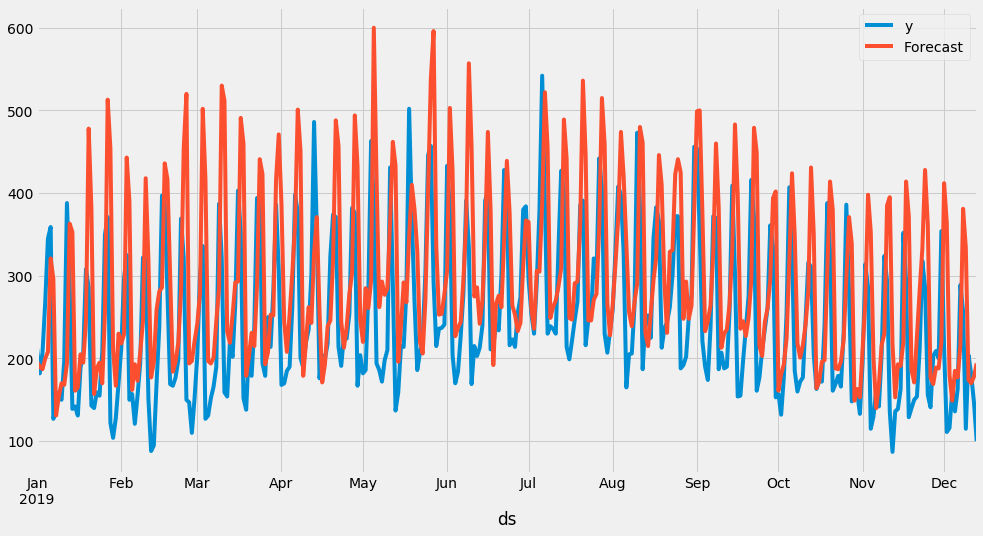

In [27]:
fig, ax = plt.subplots()
d_test.plot(label='observed',ax=ax)
pd.DataFrame(forecast,index=d_test.index,columns=['Forecast']).plot(ax=ax)
plt.legend()
plt.show()

In [28]:
rmse_test = math.sqrt(mean_squared_error(d_test.values,forecast))
print("The root mean squared error is {}.".format(rmse_test))

The root mean squared error is 111.11831324720916.


In [29]:
mape = np.mean(np.abs((np.array(d_test.y) - np.array(forecast)) / np.array(d_test.y))) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 39.03270441417742.


In [30]:
error_vals.append(('seasonal persistence baseline',rmse_train,rmse_test,mape))

### ARIMA

- finding parameters p and q for ARIMA model using 'AIC' and 'BIC'

In [31]:
order_aic_bic =[]
for p in range(8):
    for q in range(8):
        try:
            model = SARIMAX(d_train, order=(p,1,q))
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
            print('ARIMA({},{}) - AIC:{}, BIC:{}'.format(p, q, results.aic, results.bic))
        except:
            continue
order_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'aic', 'bic'])

ARIMA(0,0) - AIC:26513.395711728022, BIC:26519.087368550834
ARIMA(0,1) - AIC:26435.959425221794, BIC:26447.342738867414
ARIMA(0,2) - AIC:25368.301867663038, BIC:25385.37683813147
ARIMA(0,3) - AIC:25361.72594598758, BIC:25384.49257327882
ARIMA(0,4) - AIC:24990.407540470187, BIC:25018.865824584238
ARIMA(0,5) - AIC:25602.986169733573, BIC:25637.136110670435
ARIMA(0,6) - AIC:25001.156688631392, BIC:25040.998286391066
ARIMA(0,7) - AIC:24591.434979011916, BIC:24636.9682335944
ARIMA(1,0) - AIC:26498.69020289476, BIC:26510.07351654038
ARIMA(1,1) - AIC:26315.43901142264, BIC:26332.513981891072
ARIMA(1,2) - AIC:25366.61789070423, BIC:25389.384517995473
ARIMA(1,3) - AIC:25345.78665403611, BIC:25374.244938150165
ARIMA(1,4) - AIC:24948.400634386904, BIC:24982.550575323767
ARIMA(1,5) - AIC:25596.933649022238, BIC:25636.775246781912
ARIMA(1,6) - AIC:24966.142559979504, BIC:25011.67581456199
ARIMA(1,7) - AIC:24577.11624641651, BIC:24628.341157821804
ARIMA(2,0) - AIC:26026.990207934414, BIC:26044.06517

In [32]:
print(order_df.sort_values('aic').iloc[0,:])
print(order_df.sort_values('bic').iloc[0,:])

p          7.000000
q          7.000000
aic    22555.007886
bic    22640.382738
Name: 63, dtype: float64
p          7.000000
q          7.000000
aic    22555.007886
bic    22640.382738
Name: 63, dtype: float64


In [33]:
arima = SARIMAX(d_train, order=(7,1,7)).fit()
res = arima.resid
print(np.mean(np.abs(res)))

31.160332455252924


In [34]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2191
Model:               SARIMAX(7, 1, 7)   Log Likelihood              -11262.504
Date:                Mon, 11 May 2020   AIC                          22555.008
Time:                        19:41:15   BIC                          22640.383
Sample:                    01-01-2013   HQIC                         22586.212
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5697      0.034    -16.997      0.000      -0.635      -0.504
ar.L2         -0.5959      0.029    -20.591      0.000      -0.653      -0.539
ar.L3         -0.5814      0.031    -18.937      0.000      -0.642      -0.521
ar.L4         -0.5854      0.031    -18.788      0.000      -0.646      -0.524
ar.L5         -0.5920      0.029    -20.633      0.000      -0.648      -0.536
ar.L6         -0.5661      0.033    -17.231      0.000      -0.630      -0.502
ar.L7          0.3882      0.027     14.311      0.000       0.335       0.441
ma.L1          0.0151      0.030      0.500      0.617      -0.044       0.074
ma.L2          0.0366      0.024      1.546      0.122      -0.010       0.083
ma.L3          0.0232      0.024      0.980      0.327      -0.023       0.070
ma.L4          0.0791      0.024      3.267      0.001       0.032       0.127
ma.L5          0.0266      0.023      1.137      0.256      -0.019       0.072
ma.L6          0.0407      0.024      1.730      0.084      -0.005       0.087
ma.L7         -0.7255      0.023    -32.060      0.000      -0.770      -0.681
sigma2      1871.5643     48.160     38.861      0.000    1777.172    1965.957
===================================================================================
Ljung-Box (Q):                      105.41   Jarque-Bera (JB):               308.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- residuals are correlated and not normal

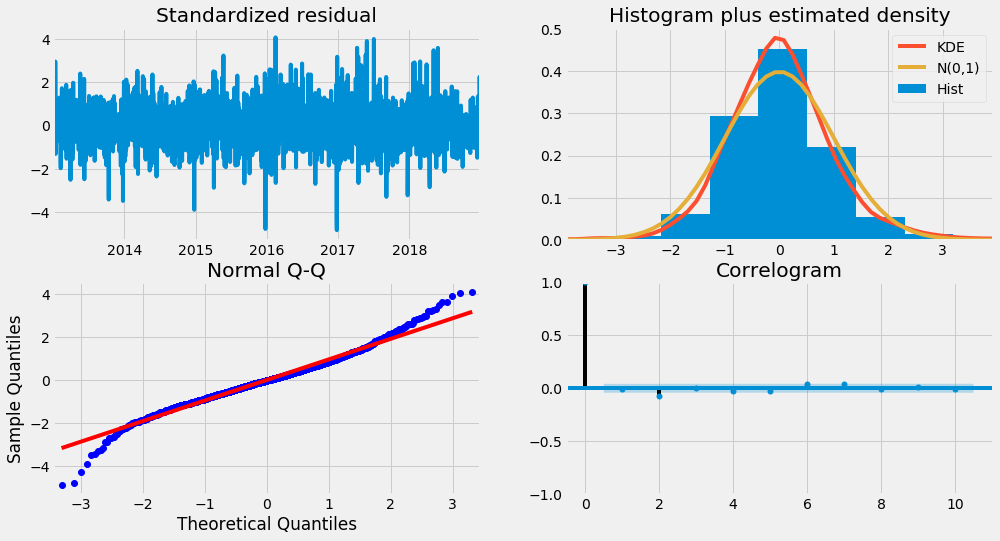

In [35]:
arima.plot_diagnostics()
plt.show()

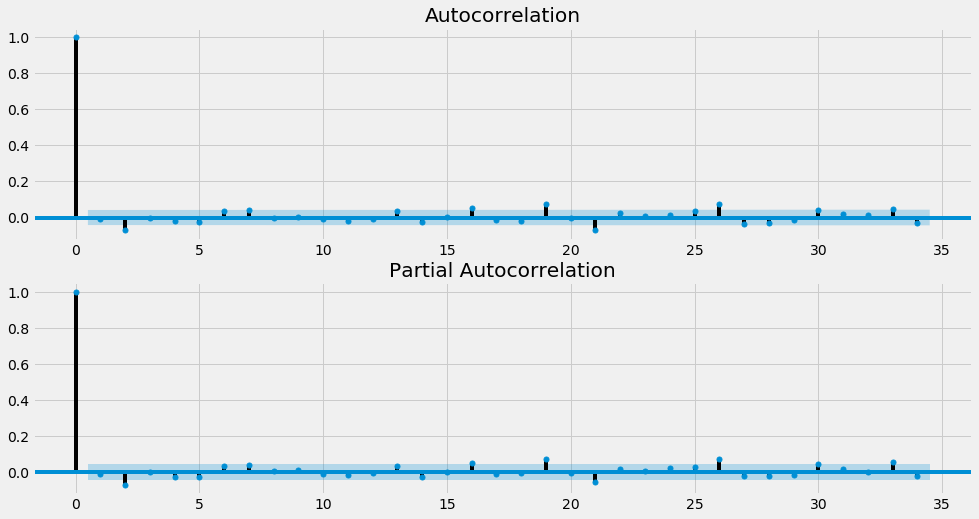

In [36]:
fig, ax = plt.subplots(2,1)
plot_acf(arima.resid,ax=ax[0])
plot_pacf(arima.resid,ax=ax[1])
plt.show()

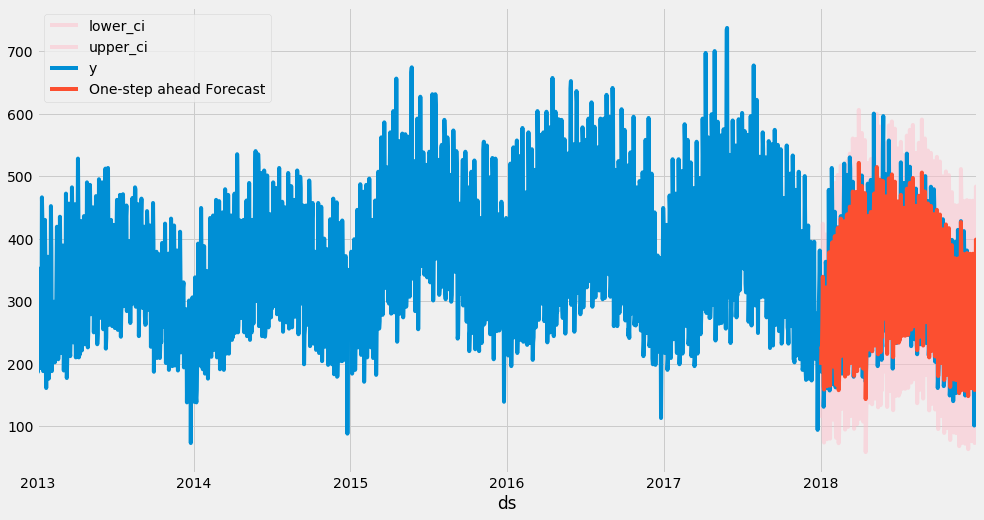

In [37]:
pred = arima.get_prediction(start=-364)
pred_ci = pred.conf_int()

fig, ax = plt.subplots()
pred_ci.iloc[:, 0].plot(ax=ax, label='lower_ci', color='pink', alpha=0.5)
pred_ci.iloc[:, 1].plot(ax=ax, label='upper_ci', color='pink', alpha=0.5)
d_train.plot(label='observed',ax=ax)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast')
plt.legend()
plt.show()

In [38]:
rmse_train = math.sqrt(mean_squared_error(d_train[-364:], pred.predicted_mean))
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is 38.8505768284382.


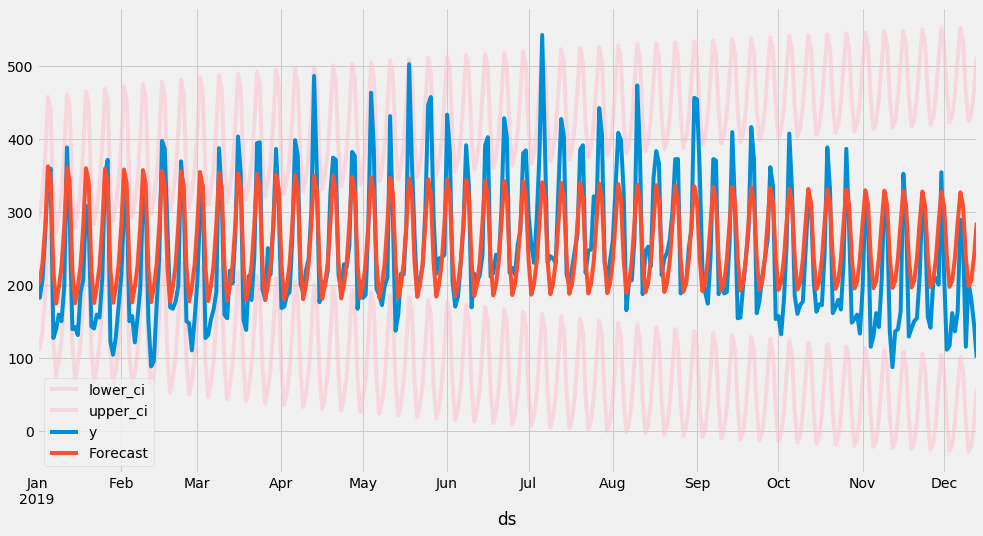

In [39]:
fcast = arima.get_forecast(steps=d_test.shape[0])
fcast_ci = fcast.conf_int()

fig, ax = plt.subplots()
fcast_ci.iloc[:, 0].plot(ax=ax, label='lower_ci', color='pink', alpha=0.5)
fcast_ci.iloc[:, 1].plot(ax=ax, label='upper_ci', color='pink', alpha=0.5)
d_test.plot(ax=ax)
fcast.predicted_mean.plot(ax=ax, label='Forecast')
plt.legend()
plt.show()

In [40]:
rmse_test = math.sqrt(mean_squared_error(d_test, fcast.predicted_mean))
print("The root mean squared error is {}.".format(rmse_test))

The root mean squared error is 57.31277614323676.


In [41]:
mape = np.mean(np.abs((np.array(d_test.y) - np.array(fcast.predicted_mean)) / np.array(d_test.y))) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 22.65643733684374.


In [42]:
error_vals.append(('arima',rmse_train,rmse_test,mape))

### SARIMA
- plotting ACF to find the period for seasonality

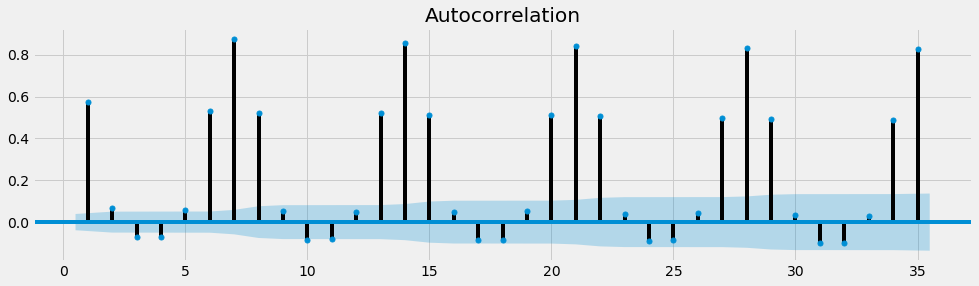

In [43]:
fig,ax = plt.subplots(figsize=(15,4))
plot_acf(daily_tor,ax=ax,zero=False)
plt.show()

- period = 7, 'weekly' seasonality
- seasonal decomposition of time series

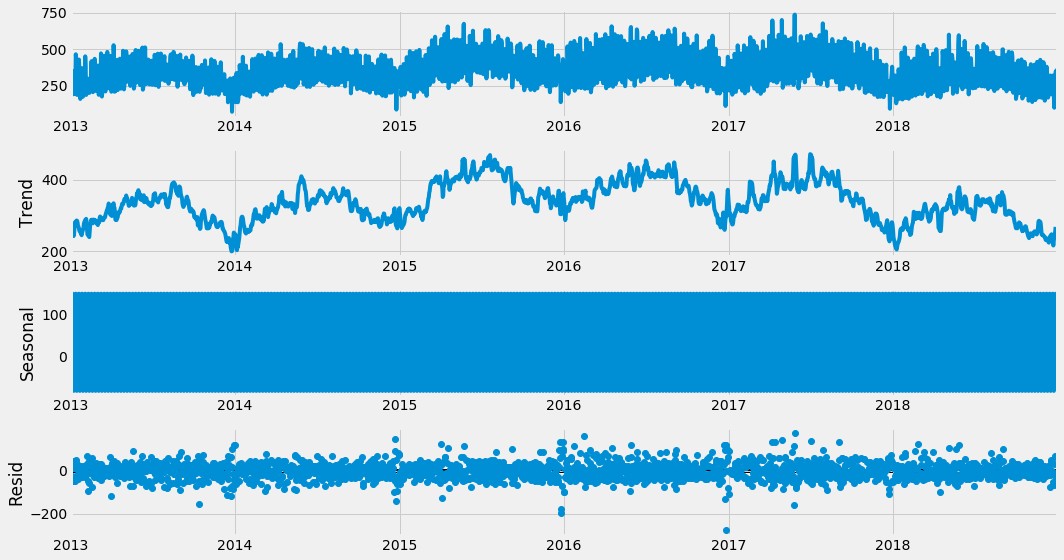

In [44]:
decomposition = sm.tsa.seasonal_decompose(d_train, model='additive',freq=7)
fig = decomposition.plot()
plt.show()

- since the seasonality is not clearly visible, drilling down on the data

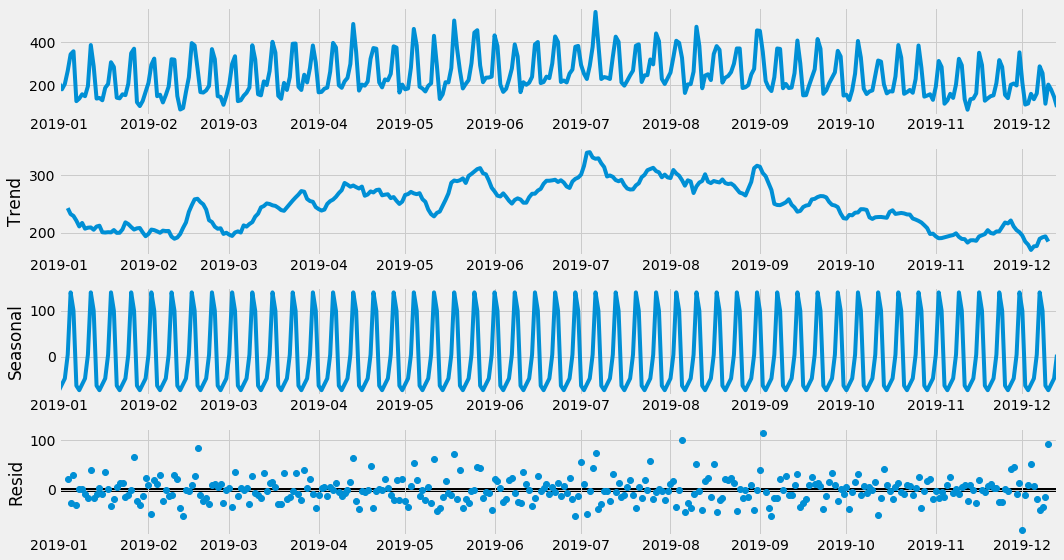

In [45]:
decomposition = sm.tsa.seasonal_decompose(d_test, model='additive',freq=7)
fig = decomposition.plot()
plt.show()

- detrending the data to remove seasonal effect

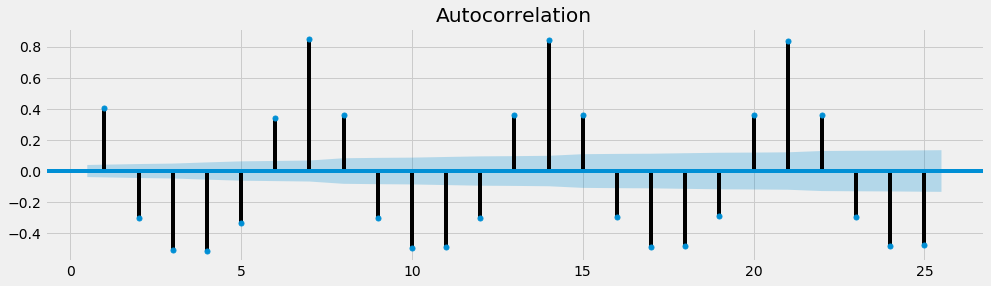

In [46]:
detrend = daily_tor - daily_tor.rolling(7).mean()
fig, ax = plt.subplots(figsize=(15,4))
plot_acf(detrend.dropna(), ax=ax, lags=25, zero=False)
plt.show()

- plotting time series, its first difference and its first seasonal difference 

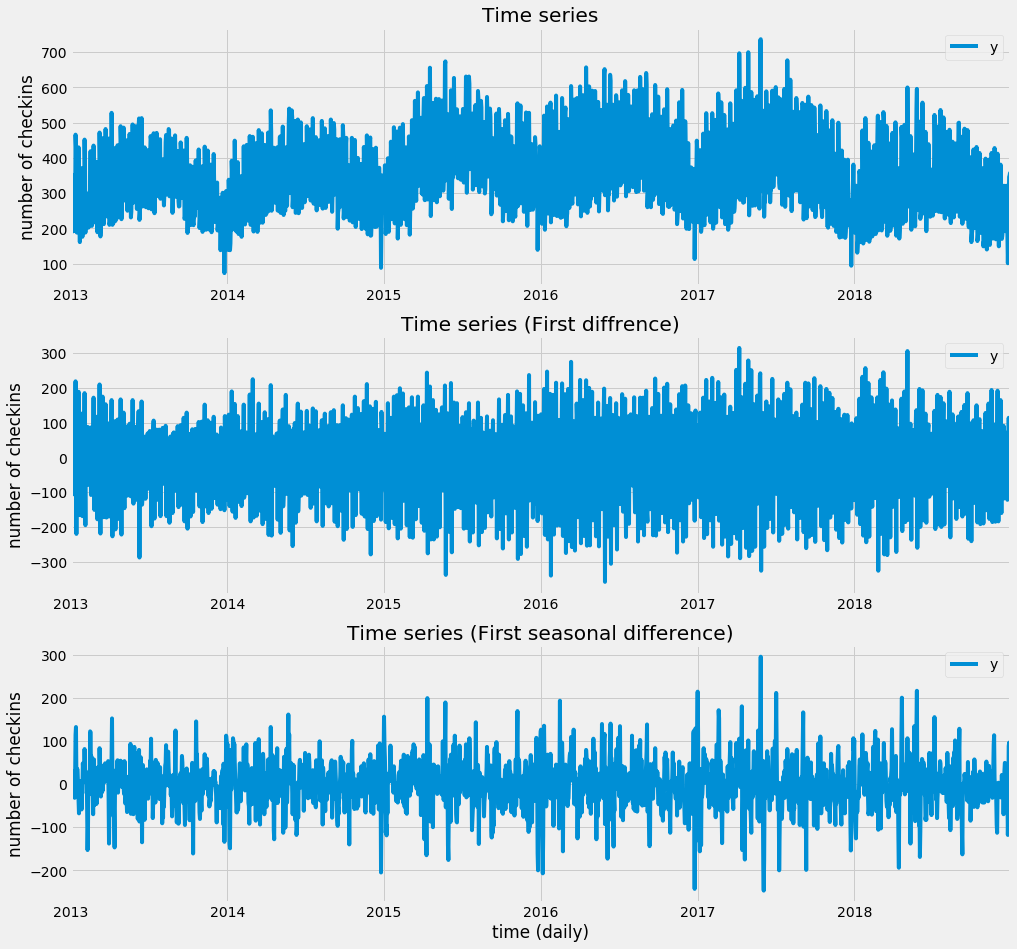

In [47]:
fig, ax = plt.subplots(3,1,figsize=(15,15))
d_train.plot(ax=ax[0])
d_train.diff().plot(ax=ax[1])
d_train.diff(7).plot(ax=ax[2])
ax[0].set(title='Time series', xlabel='', ylabel='number of checkins')
ax[1].set(title='Time series (First diffrence)', xlabel='', ylabel='number of checkins')
ax[2].set(title='Time series (First seasonal difference)', xlabel='time (daily)', ylabel='number of checkins')
plt.show()

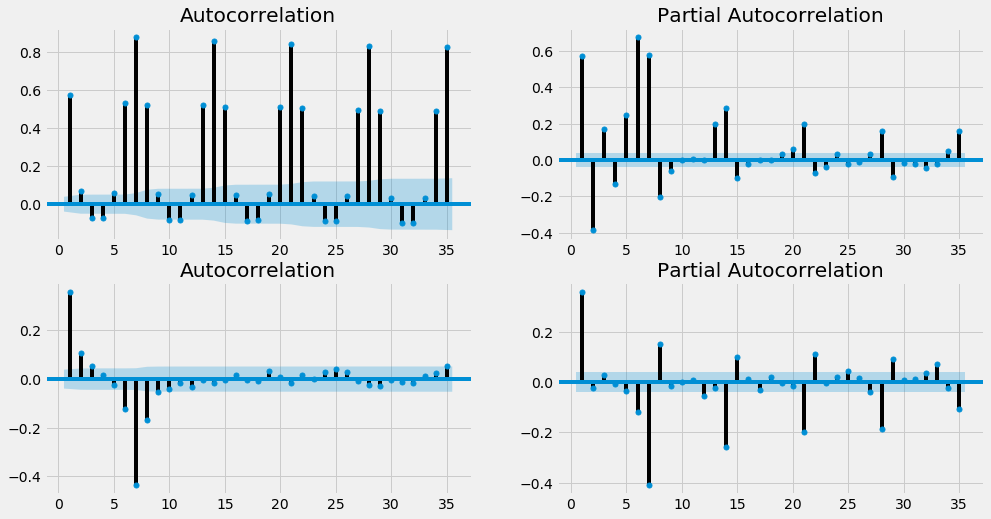

In [48]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
plot_acf(daily_tor,ax=ax[0][0],zero=False)
plot_acf(daily_tor.diff(7).dropna(),ax=ax[1][0],zero=False)
plot_pacf(daily_tor,ax=ax[0][1],zero=False)
plot_pacf(daily_tor.diff(7).dropna(),ax=ax[1][1],zero=False)
plt.show()

In [49]:
p = range(0,3)
q = range(0,3)
d1 = range(1,2)
d2 = range(0,1)
s = range(7,8)

order_aic_bic = []
pdq = list(itertools.product(p, d1, q))
seasonal_pdq = list(itertools.product(p, d2, q, s))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(d_train,
                            order=param,
                            seasonal_order=param_seasonal)
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
order_df = pd.DataFrame(order_aic_bic, columns=['param','s_param', 'aic', 'bic'])

SARIMA(0, 1, 0),(0, 0, 0, 7) - AIC:26513.395711728022
SARIMA(0, 1, 0),(0, 0, 1, 7) - AIC:25366.08266438816
SARIMA(0, 1, 0),(0, 0, 2, 7) - AIC:24809.479447019185
SARIMA(0, 1, 0),(1, 0, 0, 7) - AIC:24072.86638068585
SARIMA(0, 1, 0),(1, 0, 1, 7) - AIC:23154.72841064597
SARIMA(0, 1, 0),(1, 0, 2, 7) - AIC:23129.484052994332
SARIMA(0, 1, 0),(2, 0, 0, 7) - AIC:23714.50892092619
SARIMA(0, 1, 0),(2, 0, 1, 7) - AIC:23127.947523195748
SARIMA(0, 1, 0),(2, 0, 2, 7) - AIC:23129.64355990956
SARIMA(0, 1, 1),(0, 0, 0, 7) - AIC:26435.959425221794
SARIMA(0, 1, 1),(0, 0, 1, 7) - AIC:25057.417033738908
SARIMA(0, 1, 1),(0, 0, 2, 7) - AIC:24463.032052958446
SARIMA(0, 1, 1),(1, 0, 0, 7) - AIC:23596.146039172458
SARIMA(0, 1, 1),(1, 0, 1, 7) - AIC:22690.316780356137
SARIMA(0, 1, 1),(1, 0, 2, 7) - AIC:22674.25267235896
SARIMA(0, 1, 1),(2, 0, 0, 7) - AIC:23238.470621810717
SARIMA(0, 1, 1),(2, 0, 1, 7) - AIC:23022.516281666547
SARIMA(0, 1, 1),(2, 0, 2, 7) - AIC:22698.38173559557
SARIMA(0, 1, 2),(0, 0, 0, 7) - AIC:

In [50]:
print(order_df.sort_values('aic').iloc[0,:])
print(order_df.sort_values('bic').iloc[0,:])

param      (0, 1, 2)
s_param    (0, 1, 2)
aic          22411.1
bic            22451
Name: 51, dtype: object
param      (0, 1, 2)
s_param    (0, 1, 2)
aic          22411.1
bic            22451
Name: 51, dtype: object


In [51]:
sarima = SARIMAX(d_train,order=(0,1,2),seasonal_order=(0,1,2,7), \
                enforce_stationarity=False, enforce_invertibility=False).fit()
res = sarima.resid
print(np.mean(np.abs(res)))

30.08405269914575


In [52]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2191
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 7)   Log Likelihood              -11079.231
Date:                           Mon, 11 May 2020   AIC                          22168.462
Time:                                   19:55:36   BIC                          22196.865
Sample:                               01-01-2013   HQIC                         22178.849
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5602      0.015    -36.264      0.000      -0.590      -0.530
ma.L2         -0.3312      0.017    -19.548      0.000      -0.364      -0.298
ma.S.L7       -0.9319      0.023    -40.623      0.000      -0.977      -0.887
ma.S.L14      -0.1139      0.021     -5.461      0.000      -0.155      -0.073
sigma2      1487.6411     37.630     39.534      0.000    1413.888    1561.394
===================================================================================
Ljung-Box (Q):                       73.96   Jarque-Bera (JB):               474.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

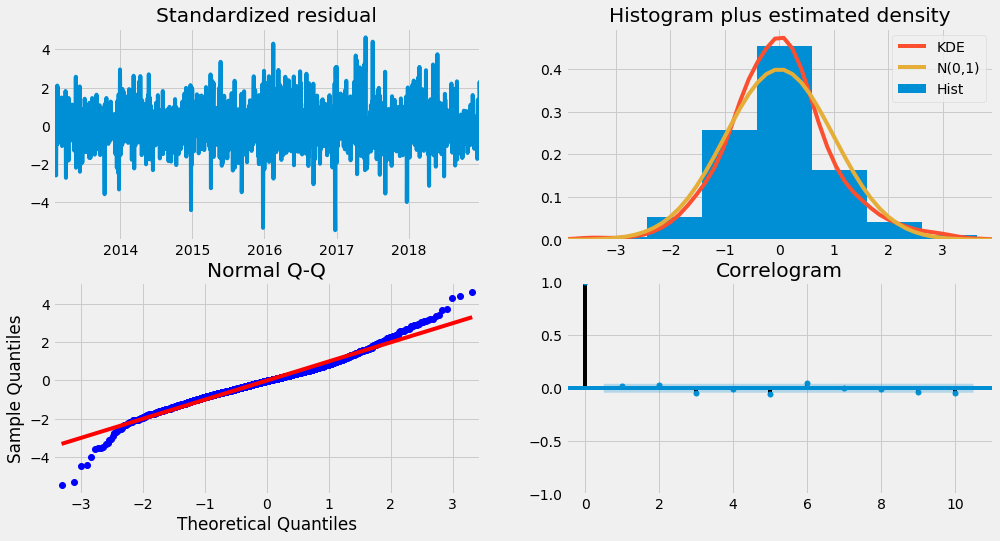

In [53]:
sarima.plot_diagnostics()
plt.show()

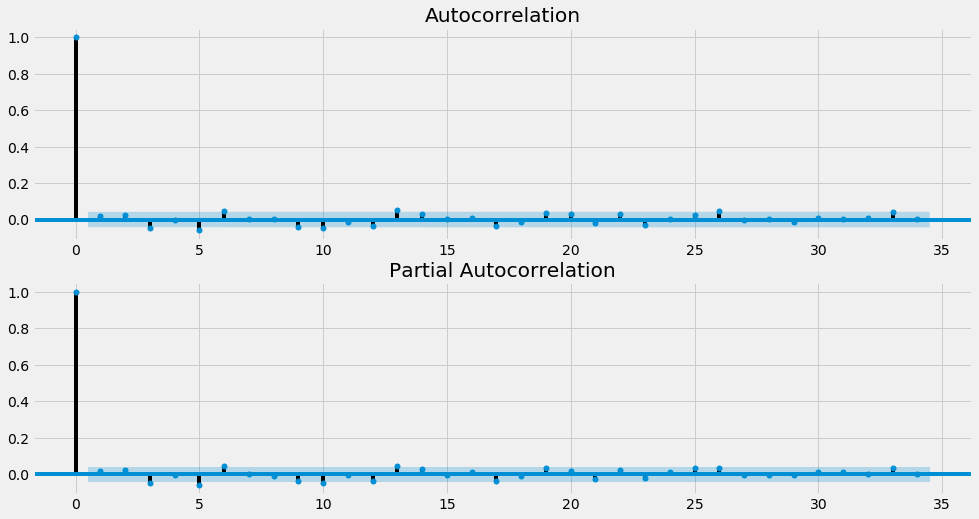

In [54]:
fig, ax = plt.subplots(2,1)
plot_acf(res,ax=ax[0])
plot_pacf(res,ax=ax[1])
plt.show()

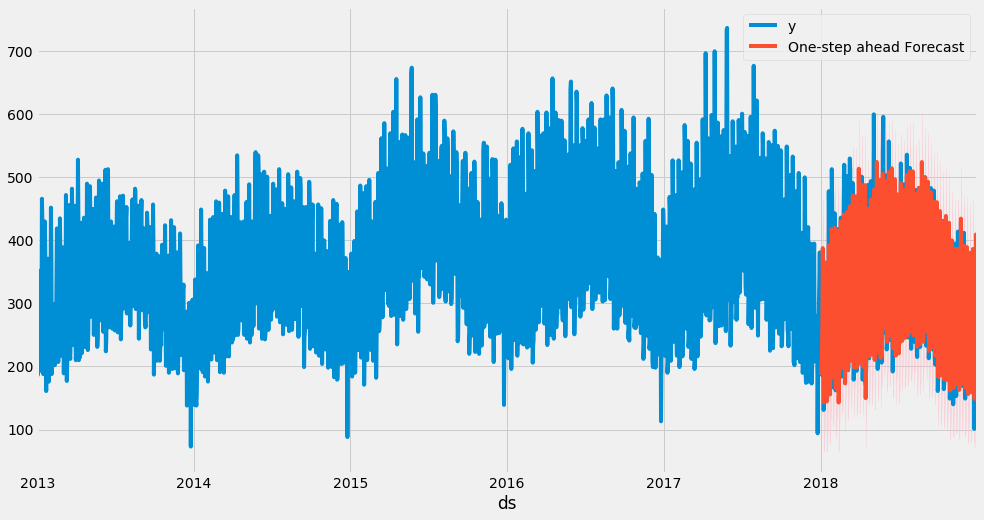

In [55]:
pred = sarima.get_prediction(start=-364)
pred_ci = pred.conf_int()

fig, ax = plt.subplots()
d_train.plot(label='observed',ax=ax)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast')
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.legend()
plt.show()

In [56]:
rmse_train = math.sqrt(mean_squared_error(d_train[-364:], pred.predicted_mean))
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is 37.36940422455303.


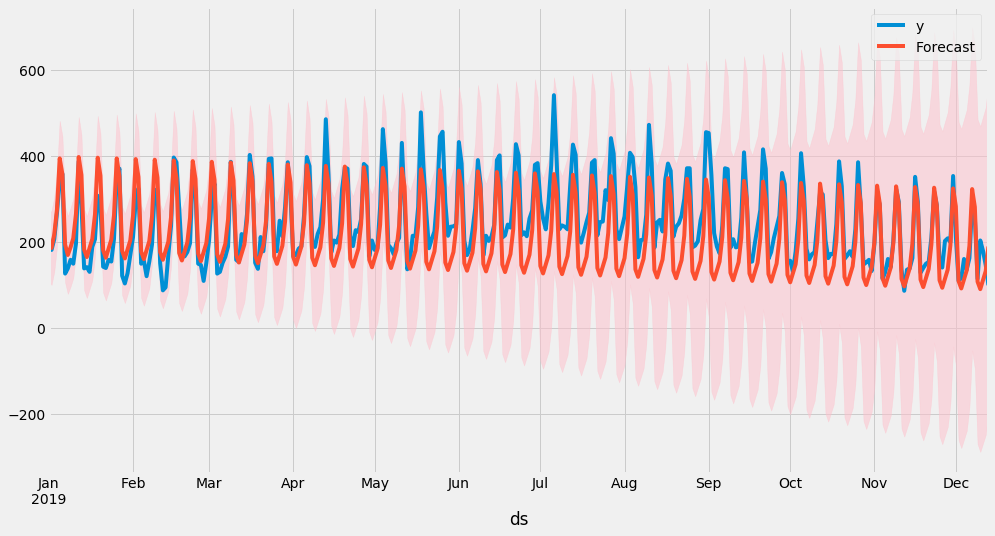

In [57]:
fcast = sarima.get_forecast(steps=d_test.shape[0])
fcast_ci = fcast.conf_int()

fig, ax = plt.subplots()
d_test.plot(label='test',ax=ax)
fcast.predicted_mean.plot(ax=ax, label='Forecast')
plt.fill_between(fcast_ci.index,
                fcast_ci.iloc[:, 0],
                fcast_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.legend()
plt.show()

In [58]:
rmse_test = math.sqrt(mean_squared_error(d_test, fcast.predicted_mean))
print("The root mean squared error is {}.".format(rmse_test))

The root mean squared error is 62.01121803577619.


In [59]:
mape = np.mean(np.abs((np.array(d_test.y) - np.array(fcast.predicted_mean)) / np.array(d_test.y))) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 21.64875791106301.


In [60]:
error_vals.append(('sarima',rmse_train,rmse_test,mape))

### SARIMA with multiple seasonalities 

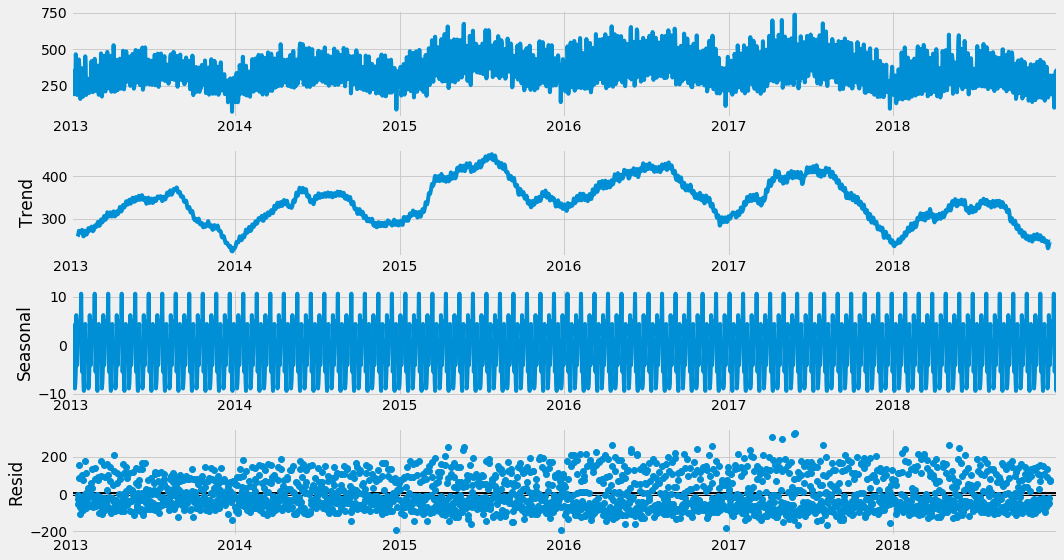

In [61]:
decomposition = sm.tsa.seasonal_decompose(d_train, model='additive',freq=30)
fig = decomposition.plot()
plt.show()

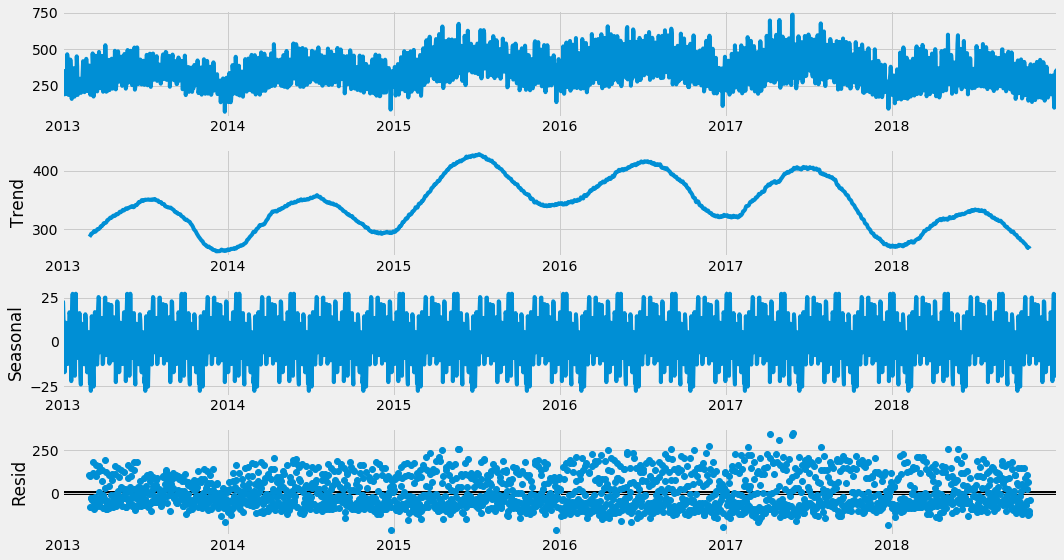

In [62]:
decomposition = sm.tsa.seasonal_decompose(d_train, model='additive',freq=120)
fig = decomposition.plot()
plt.show()

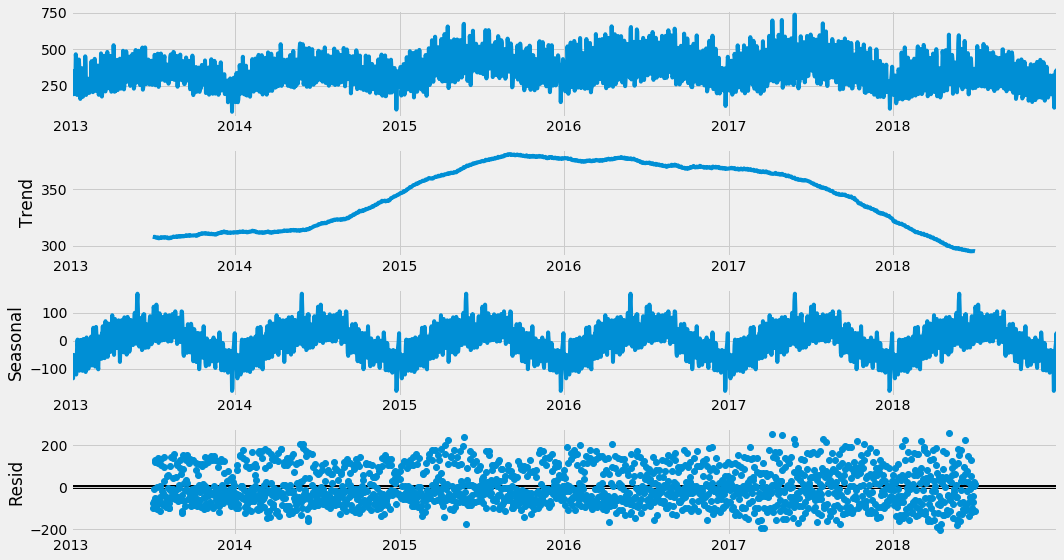

In [63]:
decomposition = sm.tsa.seasonal_decompose(d_train, model='additive',freq=365)
fig = decomposition.plot()
plt.show()

- decomposition plots for monthly and quarterly seasonalities show further seasonality components in the trend plot
- the time series shows yearly seasonality along with previously observed weekly seasonality
- using auto_arima for using multiple seasonalities to forecast 

In [64]:
exog = daily_tor.copy()
exog.drop('y',axis=1,inplace=True)
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)

In [65]:
e_train,e_test = train_test_split(exog)

(2191, 2)
(347, 2)


In [66]:
sarima_e = auto_arima(d_train, exogenous=e_train, seasonal=True,
                        m=7,error_action='ignore',trace=True,stepwise=True)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 7); AIC=22726.808, BIC=22783.724, Fit time=12.455 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=26519.309, BIC=26542.076, Fit time=0.118 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=23925.001, BIC=23959.151, Fit time=4.849 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=24996.112, BIC=25030.261, Fit time=3.985 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 7); AIC=24164.130, BIC=24215.355, Fit time=11.320 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 1, 7); AIC=22592.608, BIC=22655.217, Fit time=61.190 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 0, 7); AIC=22893.696, BIC=22950.612, Fit time=20.965 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 0, 7); AIC=23261.810, BIC=23313.035, Fit time=7.458 seconds
Fit ARIMA: order=(1, 1, 2) se

In [67]:
sarima_e.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2191
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 7)   Log Likelihood              -11181.507
Date:                             Mon, 11 May 2020   AIC                          22383.015
Time:                                     20:02:41   BIC                          22439.931
Sample:                                          0   HQIC                         22403.817
                                            - 2191                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7.806e-06   2.78e-05     -0.280      0.779   -6.24e-05    4.67e-05
x1             4.2801      2.757      1.552      0.121      -1.124       9.684
x2           -52.7933      2.708    -19.493      0.000     -58.101     -47.485
ar.L1          0.2055      0.044      4.660      0.000       0.119       0.292
ma.L1         -0.7870      0.046    -17.196      0.000      -0.877      -0.697
ma.L2         -0.2122      0.046     -4.646      0.000      -0.302      -0.123
ar.S.L7        1.0869      0.023     47.986      0.000       1.043       1.131
ar.S.L14      -0.0874      0.023     -3.864      0.000      -0.132      -0.043
ma.S.L7       -0.8868      0.012    -73.825      0.000      -0.910      -0.863
sigma2      1539.2310     33.898     45.407      0.000    1472.791    1605.671
===================================================================================
Ljung-Box (Q):                       78.00   Jarque-Bera (JB):               437.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

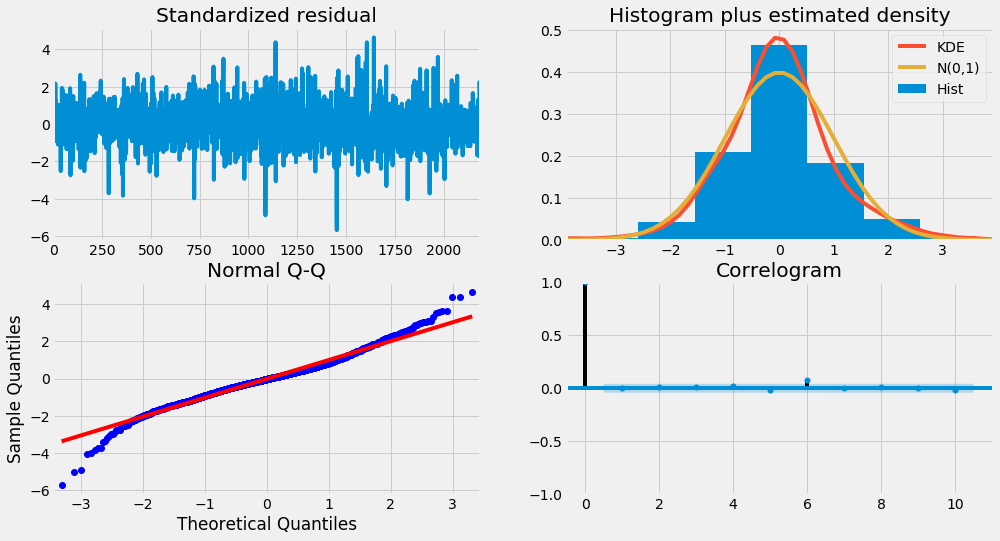

In [68]:
sarima_e.plot_diagnostics()
plt.show()

In [69]:
rmse_train = None
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is None.


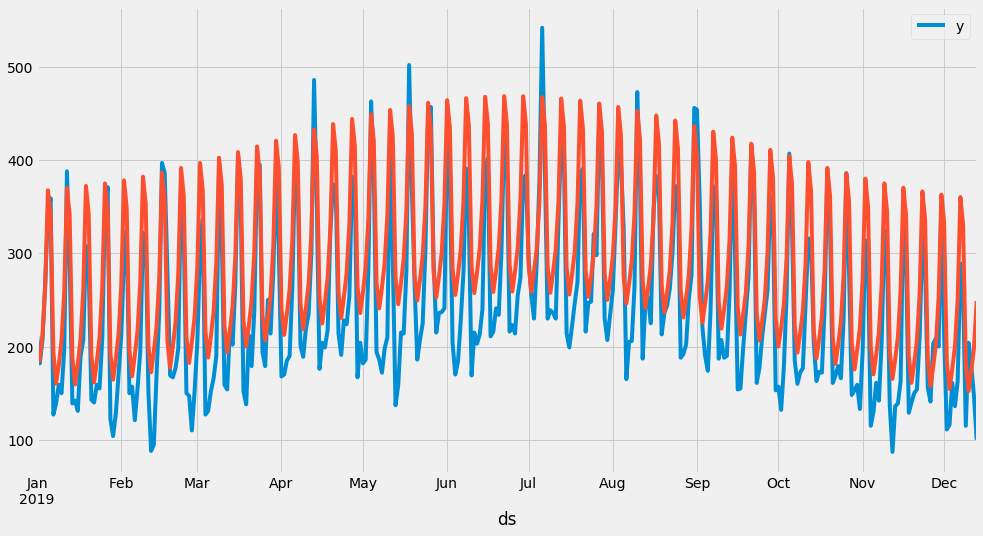

In [70]:
prediction = sarima_e.predict(n_periods=d_test.shape[0], exogenous=e_test)
fcast = pd.DataFrame(prediction, index=d_test.index, columns=['predicted_mean'])

fig, ax = plt.subplots()
d_test.plot(label='test',ax=ax)
fcast.predicted_mean.plot(ax=ax, label='Forecast')
plt.show()

In [71]:
rmse_test = math.sqrt(mean_squared_error(d_test, fcast.predicted_mean))
print("The root mean squared error is {}.".format(rmse_test))

The root mean squared error is 56.59938944691385.


In [72]:
mape = np.mean(np.abs((np.array(d_test.y) - np.array(fcast.predicted_mean)) / np.array(d_test.y))) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 24.45699440704139.


In [73]:
error_vals.append(('sarima_e',rmse_train,rmse_test,mape))

### Prophet

In [97]:
prophet = Prophet(interval_width=0.95).fit(d_train.reset_index())

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [98]:
future_pd = prophet.make_future_dataframe(
  periods=d_test.shape[0], 
  freq='D', 
  include_history=True
  )

forecast_pd = prophet.predict(future_pd)

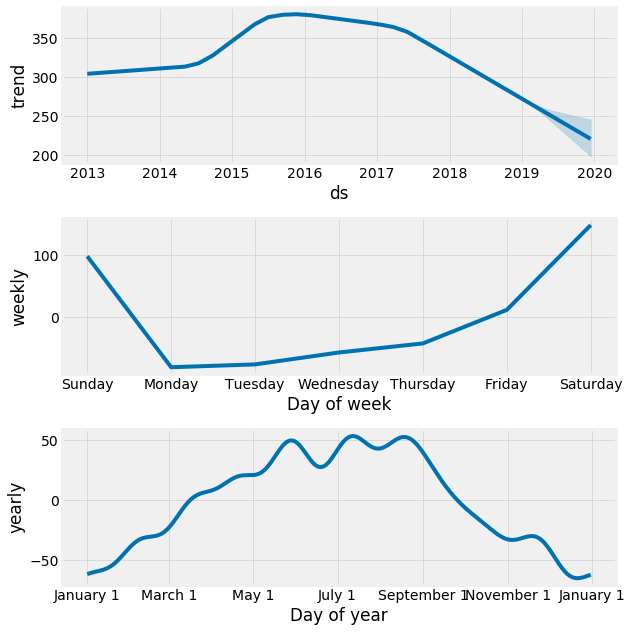

In [99]:
prophet.plot_components(forecast_pd)
plt.show()

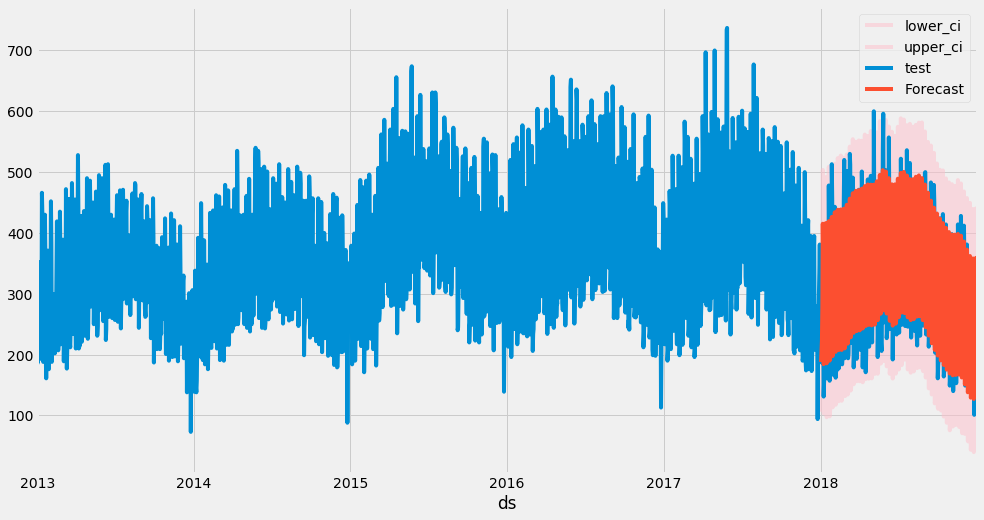

In [100]:
pred = prophet.predict(d_train[-364:].reset_index())

fig, ax = plt.subplots()
pred.plot(x='ds',y='yhat_lower',ax=ax, label='lower_ci',color='pink',alpha=0.5)
pred.plot(x='ds',y='yhat_upper',ax=ax, label='upper_ci',color='pink',alpha=0.5)
d_train.reset_index().plot(x='ds',y='y',label='test',ax=ax)
pred.plot(x='ds',y='yhat',ax=ax, label='Forecast')
plt.legend()
plt.show()

In [101]:
rmse_train = math.sqrt(mean_squared_error(d_train[-364:], pred.yhat))
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is 40.615588242679216.


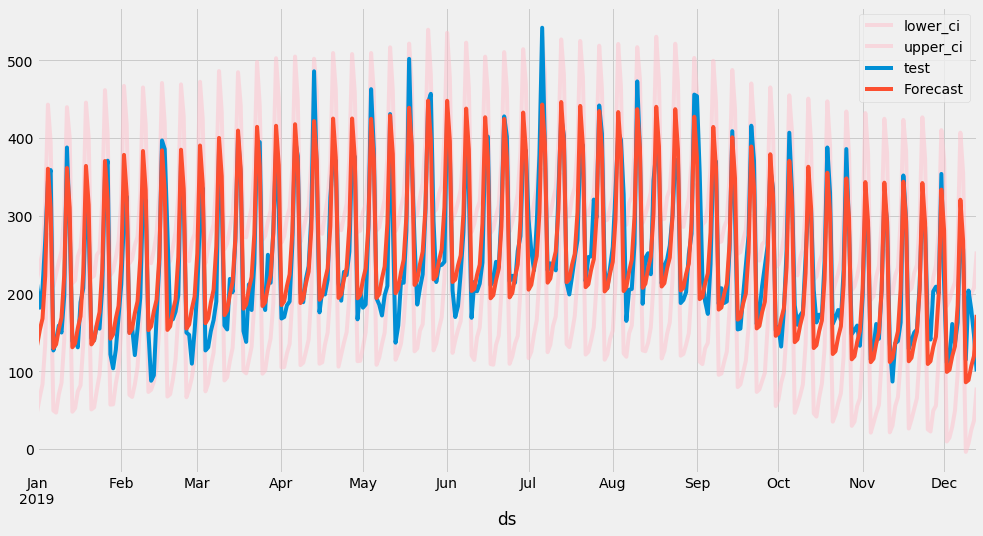

In [102]:
fcast = prophet.predict(d_test.reset_index())

fig, ax = plt.subplots()
fcast.plot(x='ds',y='yhat_lower',ax=ax, label='lower_ci',color='pink',alpha=0.5)
fcast.plot(x='ds',y='yhat_upper',ax=ax, label='upper_ci',color='pink',alpha=0.5)
d_test.reset_index().plot(x='ds',y='y',label='test',ax=ax)
fcast.plot(x='ds',y='yhat',ax=ax, label='Forecast')
plt.legend()
plt.show()

In [103]:
rmse_test = math.sqrt(mean_squared_error(d_test, fcast.yhat))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 32.653668619653295.


In [104]:
mape = np.mean(np.abs((np.array(d_test.y) - np.array(fcast.yhat)) / np.array(d_test.y))) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 12.303831080586608.


In [105]:
error_vals.append(('prophet_default',rmse_train,rmse_test,mape))

In [106]:
print(prophet.growth,
prophet.holidays,
prophet.holidays_prior_scale,
prophet.n_changepoints,
prophet.changepoint_range,
prophet.changepoint_prior_scale,
prophet.seasonality_mode,
prophet.seasonality_prior_scale,
prophet.daily_seasonality,
prophet.weekly_seasonality,
prophet.yearly_seasonality
)

linear None 10.0 25 0.8 0.05 additive 10.0 auto auto auto


### Prophet - modified parameters from observation

In [107]:
prophet_n = Prophet(interval_width=0.95,
        growth='linear', # no saturation in TS
        seasonality_mode='additive', # trend seems to have an impact on seasonal growth
        holidays_prior_scale=20, # increasing holidays influence
        changepoint_prior_scale=1, # slightly increasing changepoints influence
        seasonality_prior_scale=20, # increasing seasonality influence
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        mcmc_samples=0, # using MAP estimation
        ).add_country_holidays(
            country_name='CA' # adding canadian holidays
        ).add_seasonality(
            name='weekly',
            period=7,
            fourier_order=20
        ).add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=20
        ).fit(d_train.reset_index())

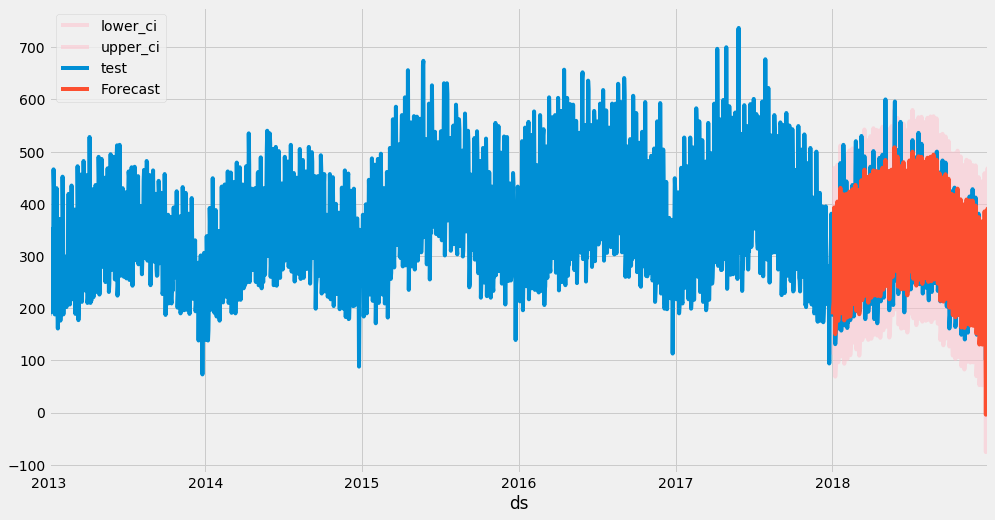

In [108]:
pred = prophet_n.predict(d_train[-364:].reset_index())

fig, ax = plt.subplots()
pred.plot(x='ds',y='yhat_lower',ax=ax, label='lower_ci',color='pink',alpha=0.5)
pred.plot(x='ds',y='yhat_upper',ax=ax, label='upper_ci',color='pink',alpha=0.5)
d_train.reset_index().plot(x='ds',y='y',label='test',ax=ax)
pred.plot(x='ds',y='yhat',ax=ax, label='Forecast')
plt.legend()
plt.show()

In [109]:
rmse_train = math.sqrt(mean_squared_error(d_train[-364:], pred.yhat))
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is 36.58213529684986.


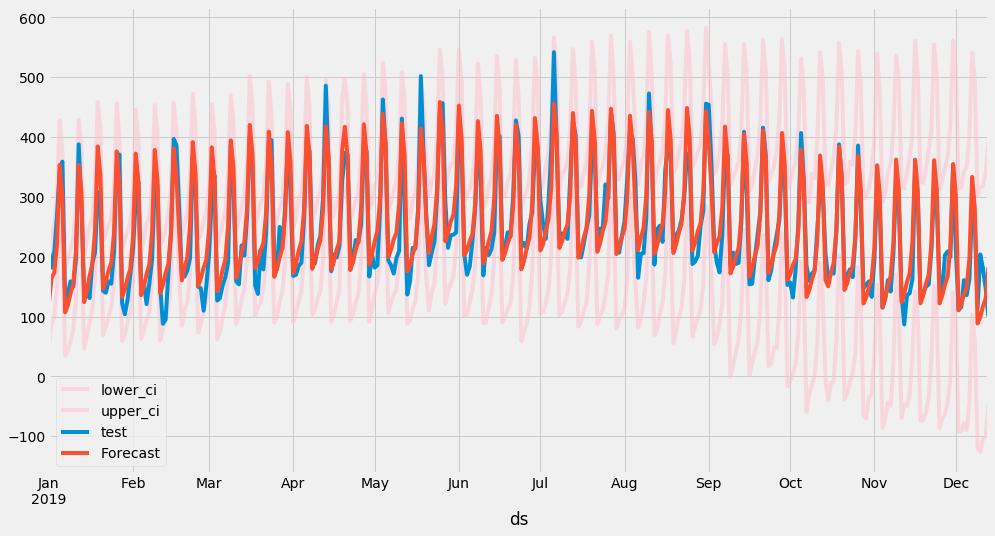

In [110]:
fcast = prophet_n.predict(d_test.reset_index())

fig, ax = plt.subplots()
fcast.plot(x='ds',y='yhat_lower',ax=ax, label='lower_ci',color='pink',alpha=0.5)
fcast.plot(x='ds',y='yhat_upper',ax=ax, label='upper_ci',color='pink',alpha=0.5)
d_test.reset_index().plot(x='ds',y='y',label='test',ax=ax)
fcast.plot(x='ds',y='yhat',ax=ax, label='Forecast')
plt.legend()
plt.show()

In [111]:
rmse_test = math.sqrt(mean_squared_error(d_test, fcast.yhat))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 32.653668619653295.


In [112]:
mape = np.mean(np.abs((np.array(d_test.y) - np.array(fcast.yhat)) / np.array(d_test.y))) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 11.668117840071995.


In [113]:
error_vals.append(('prophet_tuned',rmse_train,rmse_test,mape))

In [114]:
errors = dict()
errors['model'] = []
errors['rmse_train'] = []
errors['rmse_test'] = []
errors['mape'] = []

for row in error_vals:
    errors['model'].append(row[0])
    errors['rmse_train'].append(row[1])
    errors['rmse_test'].append(row[2])
    errors['mape'].append(row[3])

pd.DataFrame(errors)

model  rmse_train   rmse_test       mape
0  seasonal persistence baseline  128.675227  111.118313  39.032704
1                          arima   38.850577   57.312776  22.656437
2                         sarima   37.369404   62.011218  21.648758
3                       sarima_e         NaN   56.599389  24.456994
4                prophet_default   40.615588   35.651737  12.303831
5                  prophet_tuned   36.582135   32.653669  11.668118

### Forecasts

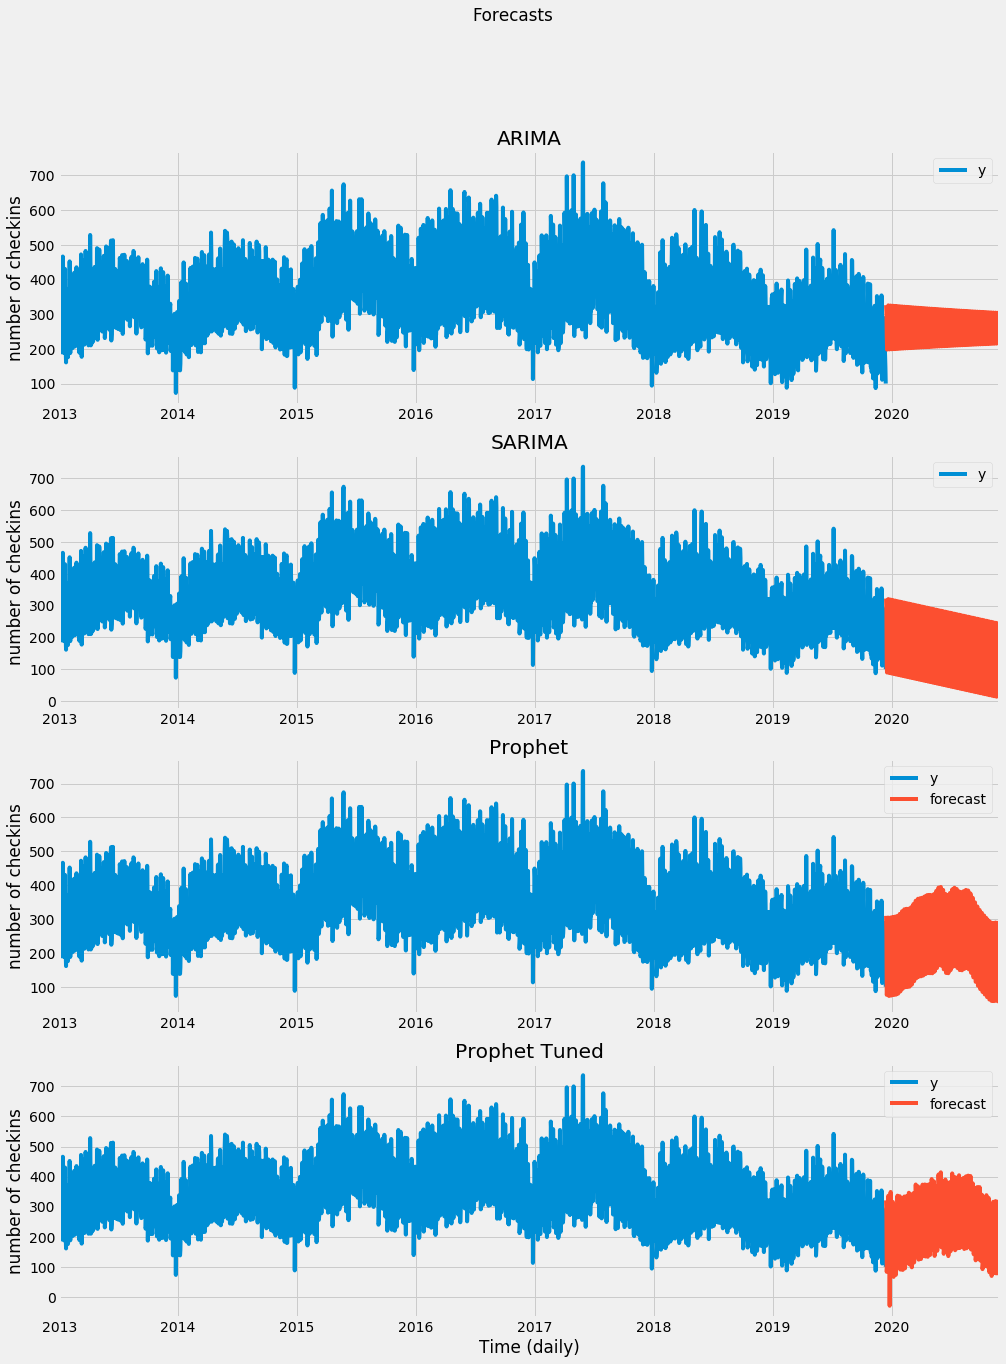

In [115]:
fcast_pd = prophet.make_future_dataframe(
  periods=d_test.shape[0]*2, 
  freq='D')

fig,ax = plt.subplots(4,1,figsize=(15,20))
daily_tor.plot(ax=ax[0], label='daily checkins')
arima.get_forecast(steps=d_test.shape[0]*2).predicted_mean[d_test.shape[0]:] \
        .plot(ax=ax[0],label='forecast')
daily_tor.plot(ax=ax[1], label='daily checkins')
sarima.get_forecast(steps=d_test.shape[0]*2).predicted_mean[d_test.shape[0]:] \
        .plot(ax=ax[1],label='forecast')
daily_tor.plot(ax=ax[2], label='daily checkins')
prophet.predict(fcast_pd)[-1*d_test.shape[0]:] \
        .plot(x='ds',y='yhat',ax=ax[2],label='forecast')
daily_tor.plot(ax=ax[3], label='daily checkins')
prophet_n.predict(fcast_pd)[-1*d_test.shape[0]:] \
        .plot(x='ds',y='yhat',ax=ax[3],label='forecast')
plt.legend()
ax[0].set(title='ARIMA',xlabel='',ylabel='number of checkins')
ax[1].set(title='SARIMA',xlabel='',ylabel='number of checkins')
ax[2].set(title='Prophet',xlabel='',ylabel='number of checkins')
ax[3].set(title='Prophet Tuned',xlabel='Time (daily)',ylabel='number of checkins')
fig.suptitle('Forecasts')
plt.show()